In [ ]:
#REvisar:

#Cosntruir posicion(j)
#Dudas sobre las dimensiones de Kappa
#Derivar V(t) directamente

In [1]:
import scipy
from scipy.integrate import solve_ivp

def exponential_decay(t, y): return [-0.5 * y[0],0.7 * y[1] + y[0]**5]

sol = solve_ivp(exponential_decay, [0, 1], [2,2])
#print(sol.y[1])
import matplotlib.pyplot as plt
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[1])
plt.show()
print(sol.t)

ModuleNotFoundError: No module named 'numpy'

In [2]:
import scipy
import pandas as pd
import numpy as np

#Importo parámetros:
parametros = pd.read_csv('parametros.csv', delimiter='\t', header=0)
#Para ver la tabla de parametros:
#parametros
[tmax,R0,Rmax,T0,Tmax,sigmaT] = parametros.number

def parameter_functions(tmax,R0,Rmax,T0,Tmax,sigmaT):
    #Radio de la burbuja
    def R(t): #en centimetros
        return 1e-2*( (Rmax-R0)/tmax*t  + R0)

    #Volumen de la burbuja:
    def V(t): #en cm3
        return 4/3 * scipy.pi * R(t)**3

    #Derivada
    def dVdt(t): #en m3/s
        return 4*scipy.pi*(R(t)**2)*(Rmax-R0)/tmax

    #Temperatura
    def T(t): #en kelvin
        mean = 0
        return (Tmax-T0)*np.exp(-0.5*((t-mean)/sigmaT)**2) + T0
    return R,T,V, dVdt

[R, T, V, dVdt] = parameter_functions(tmax,R0,Rmax,T0,Tmax,sigmaT)

#Gráfico R(t):
# import matplotlib.pyplot as plt
# import numpy as np
# t_array = np.linspace(0, tmax)
# R_array = R(t_array)
# plt.plot(t_array,R_array)

#Grafico T(t):
# import matplotlib.pyplot as plt
# import numpy as np
# t_array = np.linspace(0, 3*sigmaT)
# T_array = T(t_array)
# plt.plot(t_array,T_array)



In [34]:
from asyncore import read
import pandas as pd

Tabla_reacciones = pd.read_csv('Kappa_qca.csv', delimiter='\t', header=0)
print(Tabla_reacciones)

#Reacciones consideradas de la tabla de la tesis de Gabriela Puente
reacciones_consideradas = (1,2,3)

def position(j):
    #Da el nro de fila dentro de la tabla Tabla_reacciones del archivo Kappa_qca.csv en la que se encuentra la reaccion j
    return j

def Kappa_qca(j,direction,T_):
    #Constante de la cinética química de la reacción j a temperatura T.
    #direction indica si es forward or backwards
    #En la tesis de Gabriela esta constante está enflobada en k*T^c*exp(-E/KT)
    #El orden en los arrays es el orden de las reacciones en la tesis de Gabriela, salteando las que involucran Nitrógeno
    #Estaría bueno importar todos los datos de un .txt para hacer más sencilla la modificación de los datos en caso de ser necesario.
    Tabla = Tabla_reacciones
    if direction == 'f':
        return Tabla.k_fj[position(j)]*T_**Tabla.c_fj[position(j)]*np.exp(-Tabla.E_fj_Kb[position(j)]/T_)
    if direction == 'b':
        return Tabla.k_bj[position(j)]*T_**Tabla.c_bj[position(j)]*np.exp(-Tabla.E_bj_Kb[position(j)]/T_)
    else:
        return 'error'


   j  tj          k_fj  c_fj  E_fj_Kb          k_bj  c_bj  E_bj_Kb  DeltaEj
0  0   1  1.200000e+17  -1.0        0  3.160000e+19  -1.3    59893      498
1  1   1  5.000000e+17  -1.0        0  3.540000e+17  -0.9    51217      428
2  2   0  3.870000e+04   2.7     3150  1.790000e+04   2.7     2200       -8


1.2e+17

In [35]:
import numpy as np



#Ecuaciones diferenciales
def reacciones(t,n):
    #n a priori tiene 5 componentes:
    #n = [0, 02, H, OH, H2]

    #A modo gral:
    #dn/dt = V*(cambios debido a las reacciones) + n/V dV/dt
    #donde V es el volumen de la burbuja y n el nro de partículas de una determinada especie
    #Aquí se resumen los "cambios debido a las reacciones", es decir, la función f(t,n) presente en la ec. dif de varias variables dC/dt = f(t,n) donde C es la concentración. La expresión se construye en base a las reacciones listadas en la tesis de Gabriela
    
    #Creo el vector de concentraciones para facilitar la nomenclatura.
    C = []
    for i in range(len(n)):
        C = np.append(C,n[i]/V(t))

    #Términos asocioados a cada reacción. Hacen referencia a la reacción forward
    terminos_reacc = np.zeros(3)
    terminos_reacc[0] = -Kappa_qca(0,'f',T(t))*C[0]**2 + Kappa_qca(0,'b',T(t))*C[1]
    terminos_reacc[1] = -Kappa_qca(1,'f',T(t))*C[0]*C[2] + Kappa_qca(1,'b',T(t))*C[3]
    terminos_reacc[2] = -Kappa_qca(2,'f',T(t))*C[0]*C[4] + Kappa_qca(2,'b',T(t))*C[2]*C[3]

    x = np.zeros(5)
    #Reacciones: cada renglón hace referencia a una reacción distinta

    #0:
    x[0] = terminos_reacc[0] + terminos_reacc[1] + terminos_reacc[2]
    #02:
    x[1] = -terminos_reacc[0] 
    #H:
    x[2] = terminos_reacc[1] - terminos_reacc[2]
    #OH: 
    x[3] = -terminos_reacc[1] - terminos_reacc[2]
    #H2
    x[4] = terminos_reacc[2]

    return x

def ecuaciones_diferenciales(t,n):
    x = []
    reacc_array = reacciones(t,n)
    for i in range(len(n)):
        x = np.append(x,V(t)*reacc_array[i] + n[i]*dVdt(t)/V(t))
    return x



C:\Users\lupam\AppData\Local\Temp/ipykernel_15376/2891551747.py:22: RuntimeWarning: overflow encountered in double_scalars
  terminos_reacc[0] = -Kappa_qca(0,'f',T(t))*C[0]**2 + Kappa_qca(0,'b',T(t))*C[1]
C:\Users\lupam\AppData\Local\Temp/ipykernel_15376/2891551747.py:23: RuntimeWarning: overflow encountered in double_scalars
  terminos_reacc[1] = -Kappa_qca(1,'f',T(t))*C[0]*C[2] + Kappa_qca(1,'b',T(t))*C[3]
C:\Users\lupam\AppData\Local\Temp/ipykernel_15376/2891551747.py:24: RuntimeWarning: overflow encountered in double_scalars
  terminos_reacc[2] = -Kappa_qca(2,'f',T(t))*C[0]*C[4] + Kappa_qca(2,'b',T(t))*C[2]*C[3]
C:\Users\lupam\AppData\Local\Temp/ipykernel_15376/2891551747.py:34: RuntimeWarning: invalid value encountered in double_scalars
  x[2] = terminos_reacc[1] - terminos_reacc[2]


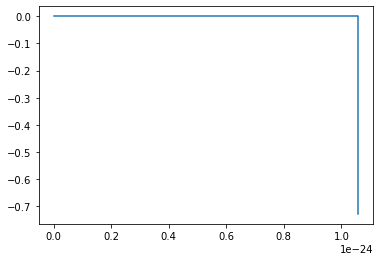

0.0 	 0.0 	 10000.0 0.0 0.0 2.0
1e-24 	 -1.703975441218108e-45 	 10000.00000000003 1.703975441218108e-45 1.703975441218108e-45 2.0000000000000058
1.0583321164659624e-24 	 -2.574368322042454e-12 	 10000.000000000031 2.5743683238734304e-12 2.574368321792775e-12 1.9999999999974318
1.0583328631170532e-24 	 -5.3459579304384195e-09 	 10000.000000001246 1.669302320005806e-08 4.1307420449302146e-09 1.9999999895881235
1.0583330124472713e-24 	 2.4501373641278386e-08 	 9999.99999998922 1.6390574727303256e-08 -1.3691062905805632e-08 1.9999999986502501
1.0583331096040915e-24 	 -3.518962365600861e-08 	 9999.999999990232 -2.5330881465245544e-08 4.498894088356657e-08 1.9999999901709764
1.0583332067609117e-24 	 -3.6907392054685616e-07 	 10000.000000033711 -5.407912701806388e-07 3.353932030563013e-07 2.0000001026990395
1.0583332125743273e-24 	 -6.087981479701365e-06 	 10000.000001154607 -5.387669113799233e-06 4.933405254704241e-06 2.0000002271319355
1.0583332127963889e-24 	 -1.2305368919406678e-05 	 100

In [37]:
#Resuelvo el sistema de ec. diff:
import scipy
from scipy.integrate import solve_ivp

sol = solve_ivp(ecuaciones_diferenciales, [0, 1e-22], [0,1e4, 0, 0, 2], method = 'RK45', max_step = 1e-24)
#Hay un problema cuando el paso es grande. Entiendo que hay errores durante el método que producen partículas negativas.


#print(sol.y[1])
import matplotlib.pyplot as plt
plt.plot(sol.t,sol.y[0])
#plt.plot(sol.t,sol.y[1] + sol.y[0])
plt.show()

for i in range(20):
    print(sol.t[i], "\t",sol.y[0][i], "\t", sol.y[1][i], sol.y[2][i], sol.y[3][i], sol.y[4][i])

In [14]:
reacciones(0,[0,1, 0, 0, 0])

array([ 1.78894682e-35, -1.78894682e-35,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00])

In [11]:
for i in range(20):
    print(sol.t[i], "\t",sol.y[0][i], "\t", sol.y[1][i], "\t", sol.y[2][i],)

IndexError: index 2 is out of bounds for axis 0 with size 2